In [1]:
import fsps
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv
from scipy import interpolate, interp
from collections import OrderedDict

matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [21]:
# These params are still wrong... need to figure out the correct ones
sp = fsps.StellarPopulation(compute_vega_mags=False,zcontinuous=1,sfh=3,
                            logzsol=0.0,dust_type=2,dust2=0.2,zred=3.0,add_igm_absorption=True)

# set_tabular_sfh(age, sfr, Z=None)
# Set a tabular SFH for use with the sfh=3 option. See the FSPS documentation for 
# information about tabular SFHs. This SFH will be piecewise linearly interpolated.

# Parameters:	
# age – Age in Gyr. ndarray of shape (ntab,)
# sfr – The SFR at each age, in Msun/yr. Must be an ndarray same length as age.
# Z – (optional) The metallicity at each age. Currently this is ignored, and the value of zmet
#   or logzsol is used for all ages. Thus setting this parameter will result in a NotImplementedError.


ages = np.linspace(0,1.0,10) # in Gyr
sfr_ages = np.ones(len(ages))*5.0 # 5 Msol/age bin ... setting the constant sfr = 5 Msun/year

print(ages)
print(sfr_ages)

sp.set_tabular_sfh(ages, sfr_ages)

[ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
  0.66666667  0.77777778  0.88888889  1.        ]
[ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]


In [22]:
age = 0.5 #Gyr
z = 3 #redshift #### For now just testing with optical filters

fsps_filters = []
fsps_filters.append(fsps.get_filter('wfc_acs_f435w'))
fsps_filters.append(fsps.get_filter('wfpc2_f606w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f775w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f850lp'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f105w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f125w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f160w'))
fsps_filters.append(fsps.get_filter('jwst_f200w'))
fsps_filters.append(fsps.get_filter('jwst_f277w'))
fsps_filters.append(fsps.get_filter('jwst_f356w'))
fsps_filters.append(fsps.get_filter('jwst_f444w'))
print(fsps_filters)

z3_mags = sp.get_mags(tage=age, bands=[f.name for f in fsps_filters])
print(z3_mags)

wave, spec = sp.get_spectrum(tage=age, peraa=True)

[<Filter(wfc_acs_f435w)>, <Filter(wfpc2_f606w)>, <Filter(wfc3_uvis_f775w)>, <Filter(wfc3_uvis_f850lp)>, <Filter(wfc3_ir_f105w)>, <Filter(wfc3_ir_f125w)>, <Filter(wfc3_ir_f160w)>, <Filter(jwst_f200w)>, <Filter(jwst_f277w)>, <Filter(jwst_f356w)>, <Filter(jwst_f444w)>]
[ 26.48553913  25.76035159  25.68076576  25.67298217  25.70807518
  25.70423185  25.35301391  25.10535654  25.10094118  24.95894819
  24.93217186]


In [23]:
# via Ned Wright's cosmology calculator: http://www.astro.ucla.edu/~wright/CosmoCalc.html
# z=3 => 25924.2 Mpc => 25924.2e+6 pc => ~ 8e+28 cm
D = 8e+28 # cm
L_sol = 3.828e+33 # erg * s^-1
flux_factor = L_sol/(4*np.pi*D**2)
jansky = 1e-23 # erg * s^-1 * cm^-2 * Hz

# Window the spectra
indices = np.where((wave >= 500) & (wave <= 20000))
useWave, useSpec = wave[indices], spec[indices]

# Convert to Jansky
useSpec = useSpec*(flux_factor/jansky)*1e+6 # micro-Janskys
z3_wave = useWave * (z+1)

colors = ["purple","blue","cyan","green", "red", "brown", "black", "red", "green", "cyan", "blue"]

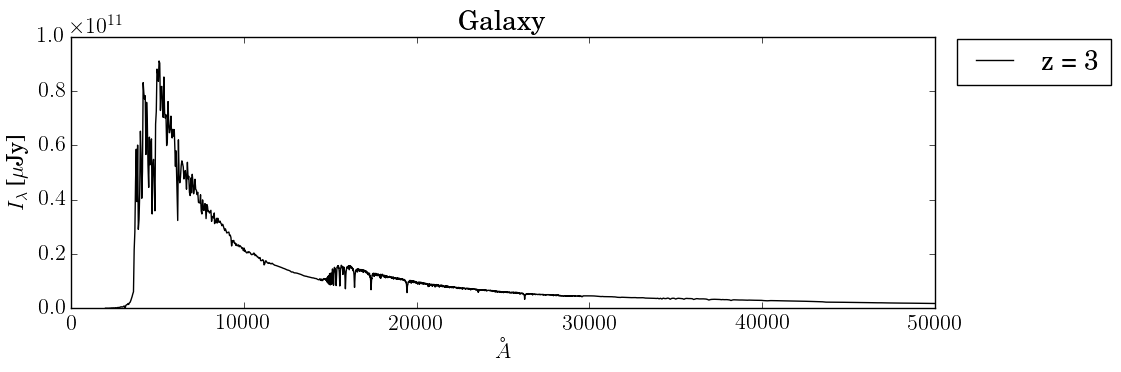

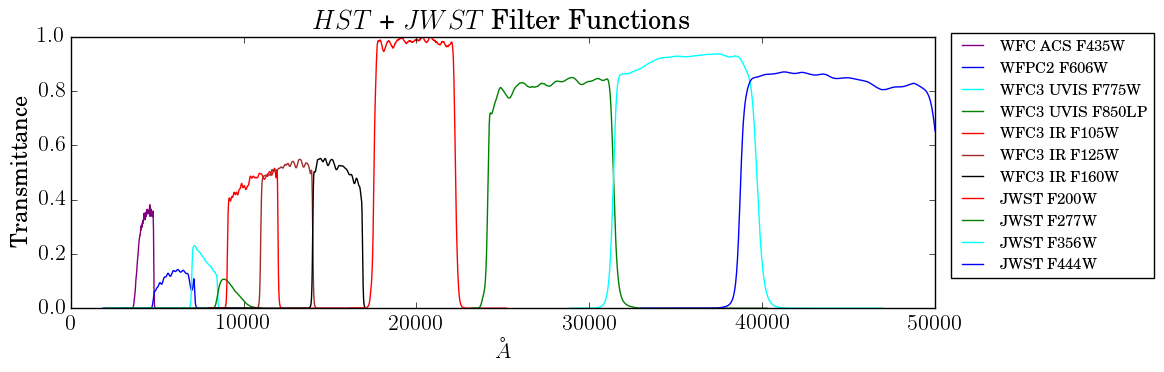

In [24]:
fig = plt.figure(figsize=(10, 4)) 
plt.plot(z3_wave,useSpec,color='k',label="z = 3")
plt.title("Galaxy")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$I_{\lambda}$  [$\mu$Jy]")
plt.xlim([0,50000])
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2)
plt.tight_layout()    
plt.show()


fig = plt.figure(figsize=(10, 4)) 
for i,f in enumerate(fsps_filters):
    plt.plot(f.transmission[0],f.transmission[1],color=colors[i],label=f.name.replace('_',' ').upper())


plt.title("$HST$ + $JWST$ Filter Functions")
plt.xlabel(r"$\AA$")
plt.ylabel("Transmittance")
plt.xlim([0,50000])
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)

plt.tight_layout()    
plt.show()

In [25]:
z3_bandpass_fluxes = OrderedDict()
for f in fsps_filters:
    filter_func = interp(z3_wave,f.transmission[0], f.transmission[1])
    z3_bandpass_fluxes[f.name] = filter_func*useSpec

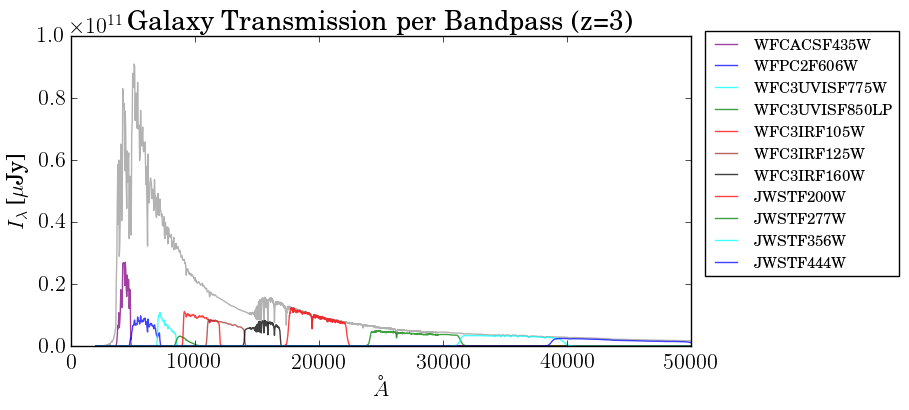

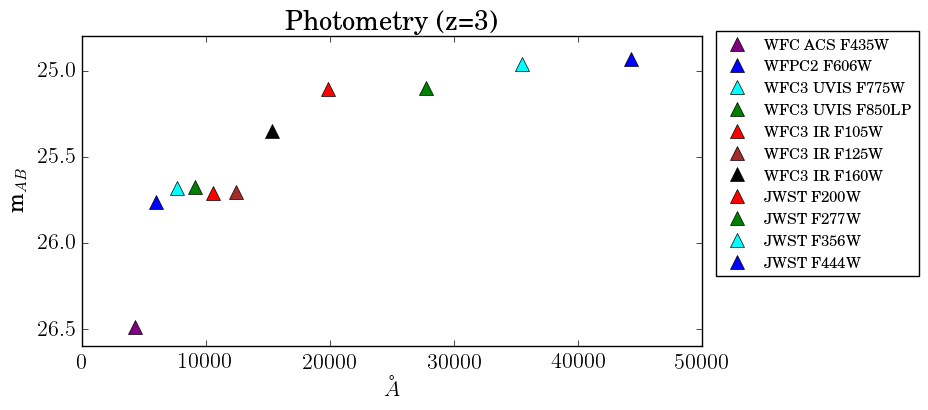

In [26]:
fig = plt.figure(figsize=(8, 4)) 

# Plot Spectra
plt.plot(z3_wave,useSpec,color='k',alpha=0.3)

# Overplot flux through each bandpass
i = 0
for name,value in z3_bandpass_fluxes.items():
    plt.plot(z3_wave,value,color=colors[i],label=name.replace('_','').upper(),alpha=0.75)    
    i+=1
    
plt.title("Galaxy Transmission per Bandpass (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"$I_{\lambda}$  [$\mu$Jy]")
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11)
plt.xlim([0,50000])
plt.show()

fig = plt.figure(figsize=(8, 4)) 

for i,m in enumerate(z3_mags):
    plt.plot(fsps_filters[i].lambda_eff,m,'^',markersize=10,color=colors[i], label=fsps_filters[i].name.replace('_',' ').upper())

plt.title("Photometry (z=3)")
plt.xlabel(r"$\AA$")
plt.ylabel(r"m_{AB}")
plt.xlim([0,50000])
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.01, 1.04),loc=2,fontsize=11,numpoints=1)
plt.show()